



<div class="row">
  <div class="column">
    <img src="../../../img/Atr_logo.png" width="250">
  </div>
</div>





# Gas turbine L1 model


The gas turbine model consists in the characterization of a twin-shaft free turbine engine architecture. This configuration was chosen because representative of the PW100 aircraft engine family, used by a large number of turboprop aircraft and which covers a wide power range between 1100 to 3700 $kW$. Assuming that these engines differ for relatively small details, the model can scale the engine to lower or higher powers within the PW100 engines power range, while providing the same specific fuel consumption. 

<div class="row">
  <div class="column">
    <img src="../../../img/gasturbine.png" width="600">
  </div>
</div>

The L1 gas turbine model evaluates the available power and the specific fuel consumption by computing the thermodynamic properties of the air flow at the inlet and the outlet of each engine component and by solving the power balance equations of the low pressure and high pressure spools. At the design point, available data from the engine’s manufacturer were used to characterize engine’s components, such as compressor pressure ratios, max turbine inlet temperature and compressors’ bleed airflow. The component efficiencies were estimated using representative values relative to the state-of-art engine technology according to [1]. The off-design analysis is performed following the method described by Mattingly [1] and Oates [2]. The components' efficiencies are assumed to be constant, therefore no scaled performance characteristics are calculated from the original performance maps. The off-design performance is calculated only by considering relations related to the gas-generator's turbine and compressor matching and the power turbine and exhaust nozzle matching.

* [1] *Mattingly, J., Elements of Gas Turbine Propulsion, McGraw-Hill, Inc., 1996*
* [2] *Oates, G. C. (1997). Aerothermodynamics of gas turbine and rocket propulsion. American Institute of Aeronautics and Astronautics.*



In [1]:
#Run this cell to import the needed modules/packages  N.B: Double click on the left to expand the window
'''
FOR THE EXTENSION OF CELL COLLAPSING:
pip install nbextension-cellfolding
jupyter nbextension install --py cellfolding --user
jupyter nbextension enable --py cellfolding --user 
'''
from fastoad.utils.physics import Atmosphere
from scipy import constants

import numpy as np
import pandas as pd
import os.path as pth
import matplotlib.pyplot as plt
from fastoad.io import VariableIO 
from fastoad.utils.postprocessing import VariableViewer

import sys
sys.path.append('C:\\Users\\LA202059\\Desktop\\RHEA\\rhea\\models\\propulsion\\fuel_engine\\turboprop_engine')
sys.path.append('C:\\Users\\LA202059\\Desktop\\RHEA\\rhea')
sys.path.append('C:\\Users\\LA202059\\Desktop\\RHEA')
from TP_engine_L1 import TPEngine_L1
from engine_components.Ram import Ram
from engine_components.Compression_Nozzle import Compression_Nozzle
from engine_components.Low_Pressure_Compressor import LPC
from engine_components.High_Pressure_Compressor import HPC
from engine_components.Combustor import Combustor
from engine_components.Low_Pressure_Turbine import LPT
from engine_components.High_Pressure_Turbine import HPT
from engine_components.Power_Turbine import Power_Turbine
from engine_components.Expansion_Nozzle import Expansion_Nozzle
from engine_components.Thrust import Thrust
from engine_components.Fuel_Data import Fuel_data
from fastoad.utils.physics import Atmosphere
from openmdao.core.explicitcomponent import ExplicitComponent
from models.propulsion.fuel_engine.turboprop_engine.engine_components.Propeller import Propeller
#sys.path
pth.__name__

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


'ntpath'

Import and modify (if needed) RHEA output file of ATR72 model 

In [2]:
INPUT_FILE = 'TPAD_baseline_inputs.xml'
vv = VariableViewer()
vv.load(INPUT_FILE)
vv.display()

In [3]:
vv.load(INPUT_FILE)
inputs=vv.get_variables()

In [4]:
#Run this cell to define the TP_sizing class

class TP_sizing:
        
    def compute(self, inputs):   
        
        Design_Thermo_Power = np.asarray(inputs["data:propulsion:Design_Thermo_Power"].value)
        inlet_pressure_ratio= np.asarray(inputs["data:propulsion:L1_engine:inlet:inlet_pressure_ratio"].value)
        combustor_pressure_ratio= np.asarray(inputs["data:propulsion:L1_engine:combustor:combustor_pressure_ratio"].value)
        T4= np.asarray(inputs["data:propulsion:L1_engine:turbine_inlet_temperature"].value)
        # temperature, density, pressure, visc, a = atmosphere(0., 0)
        altitude = 0.
        atmosphere = Atmosphere(altitude, altitude_in_feet=False)        
        
        shaft_power_adim,fuel_to_air_ratio,specific_energy,jet_power_adim,residual_thrust_nd,tau_ram,\
        tau_lpc,tau_hpc,tau_b,pi_pt,tau_pt, pi_hpc, pi_lpc, pi_ram, pi_hpt, pi_lpt, \
        tau_t,M_out_sizing = self.compute_static_power_adim(inputs)
        
        air_flow = (Design_Thermo_Power) / (shaft_power_adim )
        total_flow = air_flow * (1 + fuel_to_air_ratio)
        fuel_flow = fuel_to_air_ratio * air_flow

    	 # calculation of gas turbine dimensions    
        D_gt = 0.25*(Design_Thermo_Power)**0.12
        A_gt = np.pi*(D_gt/2)**2    
        #L_gt = 0.12*(design_TO_Shaft_Power/1000 + 22400./1000)**0.373
    
    	 # calculation of off-design constants     
        # M_out_sizing= self.nozzle.M_out_sizing  
        pi_t_sizing =pi_pt/(pi_hpt*pi_lpt)  
        tau_t_sizing = tau_t
        k1=(tau_hpc-1)*(tau_lpc*tau_ram)/tau_b
        k2=(tau_lpc-1)*tau_ram/tau_b  
        k0 = air_flow *T4**0.5/(atmosphere.pressure*pi_ram*pi_lpc*pi_hpc*inlet_pressure_ratio*combustor_pressure_ratio)
    
#         # calculation of thermal efficiency
        thermal_power = fuel_flow * specific_energy
        ESHP= shaft_power_adim * air_flow + jet_power_adim * air_flow
        jet_thrust = residual_thrust_nd*air_flow
        thermal_efficiency =  (shaft_power_adim*air_flow+jet_power_adim*air_flow)/ thermal_power   
        
        print('air_flow [kg/s]',air_flow)
        print('fuel_flow [kg/s]',fuel_flow)
        print( 'jet_thrust [N]',jet_thrust)
        print( 'thermal_efficiency',     thermal_efficiency)
        print( 'ESHP',ESHP*0.00134102)
        print('SFC_design',fuel_flow*60*60/(ESHP*1.34102/1000)*2.20462)
        
        return k0,k1,k2,tau_t_sizing,pi_t_sizing,M_out_sizing

        
    def compute_static_power_adim(self, inputs):
        """
        Computation of maximum available power.

        Uses model described in 

        :param atmosphere: Atmosphere instance at intended altitude (should be <=20km)
        :param mach: Mach number(s) (should be between 0.05 and 1.0)
        :param phase: flight phase which influences engine rating (max mechanical power)
        :param delta_t4: (unit=K) difference between T4 at flight point and design T4
        
        :return: maximum power (in W)
        """
        '''    TAXI_IN = 0
                TAKEOFF = 1
                CLIMB = 2
                CRUISE = 3
                DESCENT = 5
                LANDING = 6
                TAXI_OUT = 7'''
                

        Power_Offtake= np.asarray(inputs["data:propulsion:Power_Offtake"].value)
        fuel_type= np.asarray(inputs["data:propulsion:L1_engine:fuel"].value)


        T4= np.asarray(inputs["data:propulsion:L1_engine:turbine_inlet_temperature"].value)           
        # HP_bleed= inputs["data:propulsion:L1_engine:HP_bleed"]
        # LP_bleed= inputs["data:propulsion:L1_engine:LP_bleed"]
    
        inlet_eta_pol= np.asarray(inputs["data:propulsion:L1_engine:inlet:inlet_eta_pol"].value)
        inlet_pressure_ratio= np.asarray(inputs["data:propulsion:L1_engine:inlet:inlet_pressure_ratio"].value)
        lpc_eta_pol= np.asarray(inputs["data:propulsion:L1_engine:lpc:lpc_eta_pol"].value)
        lpc_pressure_ratio= np.asarray(inputs["data:propulsion:L1_engine:lpc:lpc_pressure_ratio"].value)
       
        hpc_eta_pol= np.asarray(inputs["data:propulsion:L1_engine:hpc:hpc_eta_pol"].value)
        hpc_pressure_ratio= np.asarray(inputs["data:propulsion:L1_engine:hpc:hpc_pressure_ratio"].value)
       
        combustor_eta= np.asarray(inputs["data:propulsion:L1_engine:combustor:combustor_eta"].value)
        combustor_pressure_ratio= np.asarray(inputs["data:propulsion:L1_engine:combustor:combustor_pressure_ratio"].value)
        
        hpt_eta_pol= np.asarray(inputs["data:propulsion:L1_engine:hpt:hpt_eta_pol"].value)
        hpt_eta_mech= np.asarray(inputs["data:propulsion:L1_engine:hpt:hpt_eta_mech"].value)

        lpt_eta_pol= np.asarray(inputs["data:propulsion:L1_engine:lpt:lpt_eta_pol"].value)
        lpt_eta_mech= np.asarray(inputs["data:propulsion:L1_engine:lpt:lpt_eta_mech"].value)

        pt_eta_pol= np.asarray(inputs["data:propulsion:L1_engine:pt:pt_eta_pol"].value)
        pt_eta_mech= np.asarray(inputs["data:propulsion:L1_engine:pt:pt_eta_mech"].value)

        nozzle_eta_pol= np.asarray(inputs["data:propulsion:L1_engine:nozzle:nozzle_eta_pol"].value)
        nozzle_pressure_ratio= np.asarray(inputs["data:propulsion:L1_engine:nozzle:nozzle_pressure_ratio"].value)
        nozzle_area_ratio= np.asarray(inputs["data:propulsion:L1_engine:nozzle:nozzle_area_ratio"].value)
        
               
                
                
                
        altitude = 0.#atmosphere.get_altitude(altitude_in_feet=False)
        mach = 0.01#np.asarray(mach)
        atmosphere=Atmosphere(altitude, altitude_in_feet=False)
       
        ram=Ram()
        ram.compute(atmosphere,mach) 
#        print 'ram', ram.stagnation_temperature,ram.stagnation_pressure
        
    
        #link inlet nozzle to ram 
        inlet=Compression_Nozzle()  
        inlet.stagnation_temperature_in             = ram.stagnation_temperature 
        inlet.stagnation_pressure_in                = ram.stagnation_pressure
	
        #Flow through the inlet nozzle
        inlet.compute(atmosphere,inlet_eta_pol,inlet_pressure_ratio)
#        print 'inlet',inlet.stagnation_temperature_out,inlet.stagnation_pressure_out,inlet.stagnation_enthalpy_out
    
        #link low pressure compressor to the inlet nozzle
        lpc =  LPC()
        lpc.stagnation_temperature_in  = inlet.stagnation_temperature_out
        lpc.stagnation_pressure_in     = inlet.stagnation_pressure_out
        #Flow through the low pressure compressor
        lpc.compute_design(lpc_pressure_ratio,lpc_eta_pol)
#        print 'lpc', lpc.stagnation_temperature_out,lpc.stagnation_pressure_out,lpc.stagnation_enthalpy_out
    
        #link the high pressure compressor to the low pressure compressor
        hpc=HPC()
        hpc.stagnation_temperature_in = lpc.stagnation_temperature_out
        hpc.stagnation_pressure_in    = lpc.stagnation_pressure_out
        #Flow through the high pressure compressor
        hpc.compute_design(hpc_pressure_ratio,hpc_eta_pol)
#        print 'hpc', hpc.stagnation_temperature_out,hpc.stagnation_pressure_out,hpc.stagnation_enthalpy_out
 
        #configure chosen fuel
        fuel = Fuel_data()   
        fuel.configure(fuel_type)
        
        #link the combustor to the high pressure compressor
        combustor =Combustor()
        combustor.stagnation_temperature_in                = hpc.stagnation_temperature_out
        combustor.stagnation_pressure_in                   = hpc.stagnation_pressure_out
        combustor.htf                                      = fuel.specific_energy    
        # combustor.TIT                                      = T4
        #flow through the high pressor comprresor
        combustor.compute_design(T4,combustor_pressure_ratio,combustor_eta,atmosphere.temperature)
#        print 'combustor', self.TP['T4'],combustor.stagnation_pressure_out,
#combustor.stagnation_enthalpy_out,combustor.fuel_to_air_ratio

        
        #link the high pressure turbine to the combustor
        hpt = HPT()
        hpt.stagnation_temperature_in    = T4
        hpt.stagnation_pressure_in       = combustor.stagnation_pressure_out
        hpt.fuel_to_air_ratio            = combustor.fuel_to_air_ratio
        #link the high pressure turbine to the high pressure compressor
        hpt.compressor_work             = hpc.work_done 
        hpt.bleed_offtake                =1.
        
        #flow through the high pressure turbine
        hpt.compute(Power_Offtake ,hpt_eta_mech, hpt_eta_pol)
#        print 'hpt',hpt.stagnation_pressure_in/hpt.stagnation_pressure_out 
#hpt.stagnation_temperature_out,hpt.stagnation_pressure_out,hpt.stagnation_enthalpy_out

        #link the low pressure turbine to the high pressure turbine
        lpt =LPT()
        lpt.stagnation_temperature_in     = hpt.stagnation_temperature_out
        lpt.stagnation_pressure_in        = hpt.stagnation_pressure_out
        lpt.fuel_to_air_ratio             = combustor.fuel_to_air_ratio
        lpt.bleed_offtake                = 1.
	
	
        #link the low pressure turbine to the low_pressure_compresor
        lpt.compressor_work            = lpc.work_done 

        #flow through the low pressure turbine
        lpt.compute(lpt_eta_pol, lpt_eta_mech)
#        print 'lpt', lpt.stagnation_pressure_in/lpt.stagnation_pressure_out,
#lpt.stagnation_temperature_out,lpt.stagnation_pressure_out,lpt.stagnation_enthalpy_out    
        #print('ITT', lpt.stagnation_temperature_out)
    
        #link low-pressure turbine output to thrust component
        thrust = Thrust()
        thrust.fuel_to_air_ratio                                = combustor.fuel_to_air_ratio
        thrust.stagnation_temperature_in                  = lpt.stagnation_temperature_out
        thrust.stagnation_pressure_in                      = lpt.stagnation_pressure_out
        
        #compute the thrust
    
        thrust.compute_design(atmosphere, mach,lpt.bleed_offtake *hpt.bleed_offtake,
                              pt_eta_mech,pt_eta_pol,nozzle_pressure_ratio,nozzle_eta_pol)     
    
        #link the power turbine to the low pressure turbine
        pt =Power_Turbine()
        pt.stagnation_enthalpy_out                  = thrust.power_turbine_ht_out
        pt.stagnation_pressure_out                  = thrust.pow_turb_Pt_out 
        pt.stagnation_temperature_out               = thrust.pow_turb_Tt_out 
        pt.stagnation_temperature_in                = lpt.stagnation_temperature_out
        pt.stagnation_pressure_in                   = lpt.stagnation_pressure_out
        pt.fuel_to_air_ratio                        = lpt.fuel_to_air_ratio
        pt.nozzle_u_out                             = thrust.nozzle_u_out                                            
        pt.bleed_offtake                            = 1.
        
        #flow through the power turbine
        pt.compute_design(pt_eta_mech,nozzle_area_ratio)
#        print 'pt',pt.stagnation_pressure_in/pt.stagnation_pressure_out ,
#pt.stagnation_temperature_out,pt.stagnation_pressure_out,pt.stagnation_enthalpy_out
        
        #link the expansion nozzle to the power turbine 
        nozzle =  Expansion_Nozzle()
        nozzle.stagnation_enthalpy_in              = pt.stagnation_enthalpy_out        
        nozzle.stagnation_temperature_in           = pt.stagnation_temperature_out 
        nozzle.stagnation_temperature_out          = thrust.nozzle_Tt_out     
        nozzle.stagnation_pressure_in              = pt.stagnation_pressure_out
        nozzle.u_out                               = thrust.nozzle_u_out 
        nozzle.M_out                               = thrust.M_out_nozzle 
        nozzle.static_temperature_out              = thrust.nozzle_T_out     
        nozzle.residual_thrust_nd                  = thrust.residual_thrust_nd                  
        #flow through theexpansion nozzle
        nozzle.compute_design(atmosphere,nozzle_pressure_ratio) 
#        print 'nozzle', nozzle.stagnation_temperature_out,nozzle.stagnation_pressure_out, nozzle.M_out    

       

        shaft_power_adim                                     = pt.shaft_takeoff  # dimensionless shaft horsepower 
        fuel_to_air_ratio                                    = combustor.fuel_to_air_ratio
        specific_energy                                      = fuel.specific_energy     
        jet_power_adim                                       = nozzle.jet_power
        residual_thrust_nd                                   = thrust.residual_thrust_nd 
        tau_ram                                              = ram.temperature_ratio
        tau_lpc                                              = lpc.temperature_ratio
        tau_hpc                                              = hpc.temperature_ratio
        tau_b                                                = combustor.tau_b
        pi_pt                                                = pt.pressure_ratio 
        tau_pt                                               = pt.temperature_ratio
        pi_hpc                                               = hpc.pressure_ratio
        pi_lpc                                               = lpc.pressure_ratio
        pi_ram                                               = ram.pressure_ratio
        pi_hpt                                               = hpt.stagnation_pressure_in/hpt.stagnation_pressure_out
        pi_lpt                                               = lpt.stagnation_pressure_in/lpt.stagnation_pressure_out
        tau_t                                               = pt.stagnation_temperature_out/hpt.stagnation_temperature_in
        M_out_sizing                                        = nozzle.M_out_sizing        
        return shaft_power_adim,fuel_to_air_ratio,specific_energy,jet_power_adim,\
                        residual_thrust_nd,tau_ram,tau_lpc,tau_hpc,tau_b,pi_pt,tau_pt, \
                            pi_hpc, pi_lpc, pi_ram, pi_hpt, pi_lpt, tau_t,M_out_sizing
    
    

In [5]:
k0,k1,k2,tau_t_sizing,pi_t_sizing,M_out_sizing = TP_sizing().compute(inputs)
print(k0,k1,k2,tau_t_sizing,pi_t_sizing,M_out_sizing)

air_flow [kg/s] 8.209845767219164
fuel_flow [kg/s] 0.19883546422252454
jet_thrust [N] 2066.9542464466876
thermal_efficiency 0.3032361286169899
ESHP 3460.4575047761714
SFC_design 0.45603331522067525
0.00023166504411705627 0.12978788226661395 0.1491267882045225 0.5906054476801195 0.08263867358169615 0.43188027934540474


In [6]:
#Definition of input variable
RTO_power=                np.asarray(inputs["data:propulsion:RTO_power"].value)
Design_Thermo_Power=      np.asarray(inputs["data:propulsion:Design_Thermo_Power"].value)
Power_Offtake=            np.asarray(inputs["data:propulsion:Power_Offtake"].value)
gearbox_eta=              np.asarray(inputs["data:propulsion:gearbox_eta"].value)
fuel=                     np.asarray(inputs["data:propulsion:L1_engine:fuel"].value)

d_prop=                     np.asarray(inputs["data:geometry:propulsion:propeller:diameter"].value)

turbine_inlet_temperature=np.asarray(inputs["data:propulsion:L1_engine:turbine_inlet_temperature"].value)
HP_bleed=                 np.asarray(inputs["data:propulsion:L1_engine:HP_bleed"].value)
LP_bleed=                 np.asarray(inputs["data:propulsion:L1_engine:LP_bleed"].value)
inlet_eta_pol=            np.asarray(inputs["data:propulsion:L1_engine:inlet:inlet_eta_pol"].value)
inlet_pressure_ratio=     np.asarray(inputs["data:propulsion:L1_engine:inlet:inlet_pressure_ratio"].value)
lpc_eta_pol=              np.asarray(inputs["data:propulsion:L1_engine:lpc:lpc_eta_pol"].value)
lpc_pressure_ratio=       np.asarray(inputs["data:propulsion:L1_engine:lpc:lpc_pressure_ratio"].value)
hpc_eta_pol=              np.asarray(inputs["data:propulsion:L1_engine:hpc:hpc_eta_pol"].value)
hpc_pressure_ratio=       np.asarray(inputs["data:propulsion:L1_engine:hpc:hpc_pressure_ratio"].value)
combustor_eta=            np.asarray(inputs["data:propulsion:L1_engine:combustor:combustor_eta"].value)
combustor_pressure_ratio=       np.asarray(inputs["data:propulsion:L1_engine:combustor:combustor_pressure_ratio"].value)
hpt_eta_pol=       np.asarray(inputs["data:propulsion:L1_engine:hpt:hpt_eta_pol"].value)
hpt_eta_mech=       np.asarray(inputs["data:propulsion:L1_engine:hpt:hpt_eta_mech"].value)
lpt_eta_pol=       np.asarray(inputs["data:propulsion:L1_engine:lpt:lpt_eta_pol"].value)
lpt_eta_mech=       np.asarray(inputs["data:propulsion:L1_engine:lpt:lpt_eta_mech"].value)
pt_eta_pol=       np.asarray(inputs["data:propulsion:L1_engine:pt:pt_eta_pol"].value)
pt_eta_mech=       np.asarray(inputs["data:propulsion:L1_engine:pt:pt_eta_mech"].value)
nozzle_eta_pol=       np.asarray(inputs["data:propulsion:L1_engine:nozzle:nozzle_eta_pol"].value)
nozzle_pressure_ratio=       np.asarray(inputs["data:propulsion:L1_engine:nozzle:nozzle_pressure_ratio"].value)
nozzle_area_ratio=           np.asarray(inputs["data:propulsion:L1_engine:nozzle:nozzle_area_ratio"].value)
k_th_RTO=                 np.asarray(inputs["settings:propulsion:ratings:RTO:k_th"].value)
k_gb_RTO=                 np.asarray(inputs["settings:propulsion:ratings:RTO:k_gb"].value)
k_th_NTO=                 np.asarray(inputs["settings:propulsion:ratings:NTO:k_th"].value)
k_gb_NTO=                 np.asarray(inputs["settings:propulsion:ratings:NTO:k_gb"].value)
k_th_MCL=                  np.asarray(inputs["settings:propulsion:ratings:MCL:k_th"].value)
k_gb_MCL=                  np.asarray(inputs["settings:propulsion:ratings:MCL:k_gb"].value)
k_th_MCT=                  np.asarray(inputs["settings:propulsion:ratings:MCT:k_th"].value)
k_gb_MCT=                   np.asarray(inputs["settings:propulsion:ratings:MCT:k_gb"].value)
k_th_MCR=                  np.asarray(inputs["settings:propulsion:ratings:MCR:k_th"].value)
k_gb_MCR=                  np.asarray(inputs["settings:propulsion:ratings:MCR:k_gb"].value)
k_th_FID=                  np.asarray(inputs["settings:propulsion:ratings:FID:k_th"].value)
k_gb_FID=                  np.asarray(inputs["settings:propulsion:ratings:FID:k_gb"].value)
k_psfc=                 np.asarray(inputs["tuning:propulsion:k_psfc"].value)
k_prop=                 np.asarray(inputs["tuning:propulsion:k_prop"].value)

TPEngine_L1=TPEngine_L1(  RTO_power,
                        Design_Thermo_Power,
                        Power_Offtake,
                        gearbox_eta,
                        d_prop,
                        fuel,
                        turbine_inlet_temperature,
                        HP_bleed,
                        LP_bleed,
                        inlet_eta_pol,
                        inlet_pressure_ratio,
                        lpc_eta_pol,
                        lpc_pressure_ratio,
                        hpc_eta_pol,
                        hpc_pressure_ratio,
                        combustor_eta,
                        combustor_pressure_ratio,
                        hpt_eta_pol,
                        hpt_eta_mech,
                        lpt_eta_pol,
                        lpt_eta_mech,
                        pt_eta_pol,
                        pt_eta_mech,
                        nozzle_eta_pol,
                        nozzle_pressure_ratio,
                        nozzle_area_ratio,       
                        k0,
                        k1,
                        k2,
                        tau_t_sizing,
                        pi_t_sizing,
                        M_out_sizing,
                        k_th_RTO,
                        k_gb_RTO,
                        k_th_NTO,
                        k_gb_NTO,
                        k_th_MCL,
                        k_gb_MCL,
                        k_th_MCT,
                        k_gb_MCT,
                        k_th_MCR,
                        k_gb_MCR,
                        k_th_FID,
                        k_gb_FID, 
                        k_psfc,
                        k_prop)

In [7]:
T4=turbine_inlet_temperature 
phase=np.array([1])   #TO = 1,MCL = 2,MCR = 3,FID = 4, RTO = 8'''
mach=0.       
altitude = 0*constants.foot

atmosphere = Atmosphere(altitude, altitude_in_feet=False)
max_shaft_power,max_thermo_power,Shp_gb_limit,engine_charac,thermo_data = TPEngine_L1.compute_power(atmosphere, mach, phase, T4)        

#deck validation
print(altitude/constants.foot,mach,float(engine_charac[1]/10),float(max_shaft_power)/constants.hp,float(engine_charac[0]*60*60),float(engine_charac[-1]))
#rating validation
# print(max_shaft_power/constants.hp,max_thermo_power/constants.hp,Shp_gb_limit/constants.hp,engine_charac[0],engine_charac[1]/10)




0.0 0.0 190.6705446438901 2415.749989411385 663.0981606086629 7.91118693473419


C:\Users\LA202059\Desktop\RHEA\rhea\models\propulsion\fuel_engine\turboprop_engine\engine_components\Thrust.py:131: RuntimeWarning: divide by zero encountered in double_scalars
  T_prop = eta_prop/u0*((ht_in-ht_out)*(1+f)*eta_mech)*bleed_offtake


## 4. Validation

The reference file "PW127F-M-N_complete_datapack.xlsx" was used to validate the results. For the ATR72 the following sheets were used: TO_M, RTO_M, MCL, MCR, FID, CR_variable.

In [68]:
path='../../resources/gasturbine/PW100/Experimental_data/'

#ref_TO = pd.read_csv(path+'PW127M_deck_SHP_TO2.txt',sep="\t")
ref_MCL = pd.read_csv(path+'PW127M_deck_SHP_MCL_full.txt',sep="\t")
ref_CR = pd.read_csv(path+'PW127M_deck_SHP_CRZ_full.txt',sep="\t")
#ref_RTO = pd.read_csv(path+'PW127M_deck_SHP_RTO2.txt',sep="\t")
#ref_FID = pd.read_csv(path+'PW127M_deck_SHP_FID.txt',sep="\t")


'''ax1 = ref_MCL.plot.scatter(x='Altitude',
                      y='SHP',
                      c='Mach',
                     colormap='viridis')

ax2 = ref_MCL.plot.scatter(x='Altitude',
                      y='PSFC',
                      c='SHP',
                     colormap='viridis')'''
ref_MCL['rating']='MCL'
ref_CR['rating']='CR'
ref_tot= ref_CR.append(ref_MCL)
ref_MCL

,Altitude,Mach,FN,WF,SHP,PSFC,Throttle,rating
0,0,0.00,2392,521.2,2192,0.237774,1,MCL
1,0,0.10,2425,519.5,2192,0.236998,1,MCL
2,0,0.15,2206,517.5,2192,0.236086,1,MCL
3,0,0.20,1909,515.2,2192,0.235036,1,MCL
4,0,0.25,1646,514.9,2192,0.234900,1,MCL
5,0,0.30,1423,513.0,2192,0.234033,1,MCL
6,0,0.35,1237,510.1,2192,0.232710,1,MCL
7,0,0.40,1082,506.4,2192,0.231022,1,MCL
8,0,0.45,944,500.6,2192,0.228376,1,MCL
9,0,0.50,807,494.1,2192,0.225411,1,MCL


Create RHEA df for MCL rating

In [8]:
T4=turbine_inlet_temperature
speeds=[0.01,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]        
altitudes = [0,2500*constants.foot,5000*constants.foot,10000*constants.foot,15000*constants.foot,20000*constants.foot,25000.*constants.foot]#,30000.*constants.foot]

def create_df(phase,throttle):
    df= pd.DataFrame()
    for mach in speeds:
        for altitude in altitudes:
            atmosphere = Atmosphere(altitude, altitude_in_feet=False)
            if throttle==1:
                max_shaft_power,max_thermo_power,Shp_gb_limit,engine_charac,thermo_data = TPEngine_L1.compute_power(atmosphere, mach, phase, T4)        
                out_power = max_shaft_power
                T_prop, eta =Propeller().power_to_thrust_ADT(TPEngine_L1,atmosphere, mach,phase, out_power)
            else:
                max_shaft_power,max_thermo_power,Shp_gb_limit,engine_charac,thermo_data = TPEngine_L1.compute_power(atmosphere, mach, phase, T4)
                out_power,thermo_power,gb_limit_power, engine_charac,thermo_data =TPEngine_L1.compute_engine_point(atmosphere, mach, phase,max_shaft_power*throttle)
                T_prop, eta =Propeller().power_to_thrust_ADT(TPEngine_L1,atmosphere, mach,phase, out_power)
                
            #deck validation
            df = df.append({'Alt_ft':altitude/constants.foot,'Mach':mach,'FN_daN':float(engine_charac[1]/10)+float(T_prop)/10, 'SHP':float(out_power)/constants.hp,'fuel_flow':float(engine_charac[0]*60*60),'air_flow':float(engine_charac[-1])}, ignore_index=True)

    return df   
            
        #rating validation
        # print(max_shaft_power/constants.hp,max_thermo_power/constants.hp,Shp_gb_limit/constants.hp,engine_charac[0],engine_charac[1]/10)
#TO = 1,MCL = 2,MCR = 3,FID = 4, RTO = 8'''
rhea_MCL=create_df(2,1)


rhea_MCL['PSFC']= rhea_MCL.fuel_flow/rhea_MCL.SHP
rhea_MCL['rating']= 'MCL'

rhea_MCL

,Alt_ft,FN_daN,Mach,SHP,air_flow,fuel_flow,PSFC,rating
0,0.0,3470.825043,0.01,2139.280824,7.404314,576.852137,0.269648,MCL
1,2500.0,3464.876368,0.01,2139.280824,6.963373,545.549927,0.255016,MCL
2,5000.0,3445.371206,0.01,2130.419645,6.543064,515.486786,0.241965,MCL
3,10000.0,3167.532306,0.01,1957.753535,5.761500,458.960113,0.234432,MCL
4,15000.0,2898.359295,0.01,1790.316608,5.054112,407.037718,0.227355,MCL
5,20000.0,2639.593631,0.01,1629.208798,4.415645,359.486897,0.220651,MCL
6,25000.0,2388.219032,0.01,1472.639485,3.841100,316.077227,0.214633,MCL
7,0.0,2747.494673,0.10,2139.280824,7.430610,578.525903,0.270430,MCL
8,2500.0,2742.087652,0.10,2139.280824,6.987930,547.127295,0.255753,MCL
9,5000.0,2736.231269,0.10,2139.280824,6.565972,516.971690,0.241657,MCL


In [12]:
rhea_MCR=create_df(3,1)
rhea_MCR_08=create_df(3,0.8)
rhea_MCR_06=create_df(3,0.6)
rhea_MCR_01=create_df(3,0.1)
rhea_MCR_04=create_df(3,0.4)
rhea_MCR['PSFC']= rhea_MCR.fuel_flow/rhea_MCR.SHP
rhea_MCR_08['PSFC']= rhea_MCR_08.fuel_flow/rhea_MCR_08.SHP
rhea_MCR_06['PSFC']= rhea_MCR_06.fuel_flow/rhea_MCR_06.SHP
rhea_MCR_01['PSFC']= rhea_MCR_01.fuel_flow/rhea_MCR_01.SHP
rhea_MCR_04['PSFC']= rhea_MCR_04.fuel_flow/rhea_MCR_04.SHP


56    0.689702
57    0.649885
58    0.612778
59    0.553106
60    0.518733
61    0.487064
62    0.457593
Name: PSFC, dtype: float64

56    0.281845
57    0.266478
58    0.251721
59    0.229297
60    0.223030
61    0.217295
62    0.211847
Name: PSFC, dtype: float64

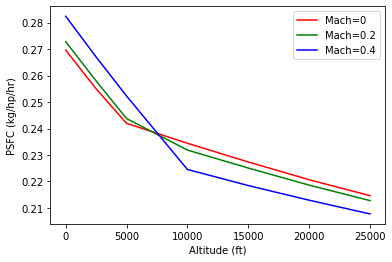

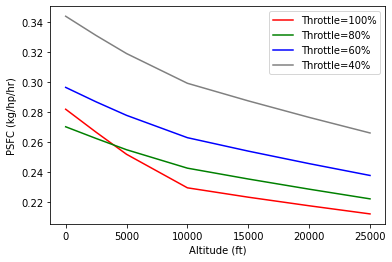

In [14]:
fig = plt.figure()
plt.plot(rhea_MCL[rhea_MCL.Mach==0.01].Alt_ft, rhea_MCL[rhea_MCL.Mach==0.01].PSFC, 'r', label='Mach=0')
plt.plot(rhea_MCL[rhea_MCL.Mach==0.2].Alt_ft, rhea_MCL[rhea_MCL.Mach==0.2].PSFC, 'g', label='Mach=0.2')
plt.plot(rhea_MCL[rhea_MCL.Mach==0.4].Alt_ft, rhea_MCL[rhea_MCL.Mach==0.4].PSFC, 'b', label='Mach=0.4')

plt.xlabel('Altitude (ft)')
plt.ylabel('PSFC (kg/hp/hr)')

plt.legend(loc='upper right')

fig = plt.figure()
plt.plot(rhea_MCR[rhea_MCR.Mach==0.45].Alt_ft, rhea_MCR[rhea_MCR.Mach==0.45].PSFC, 'r', label='Throttle=100%')
plt.plot(rhea_MCR_08[rhea_MCR_08.Mach==0.45].Alt_ft, rhea_MCR_08[rhea_MCR_08.Mach==0.45].PSFC, 'g', label='Throttle=80%')
plt.plot(rhea_MCR_06[rhea_MCR_06.Mach==0.45].Alt_ft, rhea_MCR_06[rhea_MCR_06.Mach==0.45].PSFC, 'b', label='Throttle=60%')
plt.plot(rhea_MCR_04[rhea_MCR_04.Mach==0.45].Alt_ft, rhea_MCR_04[rhea_MCR_04.Mach==0.45].PSFC, 'grey', label='Throttle=40%')

plt.xlabel('Altitude (ft)')
plt.ylabel('PSFC (kg/hp/hr)')

plt.legend(loc='upper right')

display( rhea_MCR_01[rhea_MCR_01.Mach==0.45].PSFC)
display(rhea_MCR[rhea_MCR.Mach==0.45].PSFC )


Mean squared error SHP 28381.037045399535
Mean absolute error SHP 113.07099564565236
Mean squared error PSFC 0.0006646631766294487
Mean absolute error PSFC 0.021330612369295836
Mean squared error FN 13374.603383258247
Mean absolute error FN 83.1382594353452


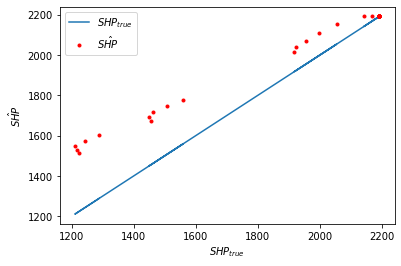

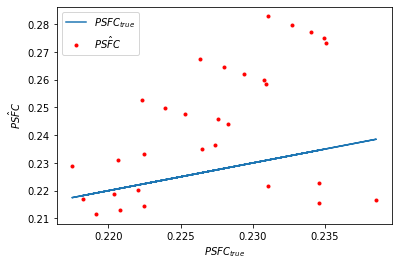

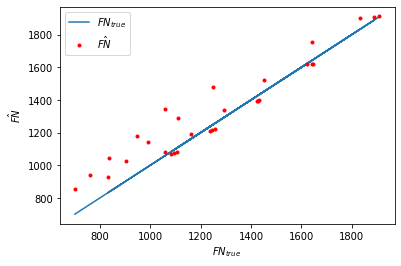

In [70]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
speeds=[0.2,0.25,0.3,0.35,0.4]        
altitudes = [0,2500,5000,10000,20000,25000.]
psfc_pred=[]
psfc_true=[]
shp_pred=[]
shp_true=[]
fn_pred=[]
fn_true=[]

for alt in altitudes:
    for mach in speeds:
        SHP_pred=rhea_MCL.loc[rhea_MCL['Alt_ft']==alt, ['SHP','Mach']].loc[rhea_MCL['Mach']==mach, ['SHP']].values[0][0]
        PSFC_pred=rhea_MCL.loc[rhea_MCL['Alt_ft']==alt, ['PSFC','Mach']].loc[rhea_MCL['Mach']==mach, ['PSFC']].values[0][0]
        FN_pred=rhea_MCL.loc[rhea_MCL['Alt_ft']==alt, ['FN_daN','Mach']].loc[rhea_MCL['Mach']==mach, ['FN_daN']].values[0][0]
        if mach==0.01:
            mach=0
        SHP_true=ref_MCL.loc[ref_MCL['Altitude']==alt, ['SHP','Mach']].loc[ref_MCL['Mach']==mach, ['SHP']].values[0][0]
        PSFC_true=ref_MCL.loc[ref_MCL['Altitude']==alt, ['PSFC','Mach']].loc[ref_MCL['Mach']==mach, ['PSFC']].values[0][0]     
        FN_true=ref_MCL.loc[ref_MCL['Altitude']==alt, ['FN','Mach']].loc[ref_MCL['Mach']==mach, ['FN']].values[0][0] 
        
        psfc_pred.append(PSFC_pred)
        psfc_true.append(PSFC_true) 
        shp_pred.append(SHP_pred)
        shp_true.append(SHP_true)
        
        fn_pred.append(FN_pred)
        fn_true.append(FN_true)

    



fig = plt.figure()
plt.plot(shp_true, shp_true, '-', label='$SHP_{true}$')
plt.plot(shp_true, shp_pred, 'r.', label='$\hat{SHP}$')
   
plt.xlabel('$SHP_{true}$')
plt.ylabel('$\hat{SHP}$')

plt.legend(loc='upper left')
print('Mean squared error SHP', mean_squared_error(shp_true,shp_pred)) 
print('Mean absolute error SHP', mean_absolute_error(shp_true,shp_pred)) 

fig = plt.figure()
plt.plot(psfc_true, psfc_true, '-', label='$PSFC_{true}$')
plt.plot(psfc_true, psfc_pred, 'r.', label='$\hat{PSFC}$')
   
plt.xlabel('$PSFC_{true}$')
plt.ylabel('$\hat{PSFC}$')

plt.legend(loc='upper left')
print('Mean squared error PSFC', mean_squared_error(psfc_true,psfc_pred)) 
print('Mean absolute error PSFC', mean_absolute_error(psfc_true,psfc_pred)) 

fig = plt.figure()
plt.plot(fn_true, fn_true, '-', label='$FN_{true}$')
plt.plot(fn_true, fn_pred, 'r.', label='$\hat{FN}$')
   
plt.xlabel('$FN_{true}$')
plt.ylabel('$\hat{FN}$')

plt.legend(loc='upper left')
print('Mean squared error FN', mean_squared_error(fn_true,fn_pred)) 
print('Mean absolute error FN', mean_absolute_error(fn_true,fn_pred))

## Create TP_L1 deck to be used to build ML model

array([   0.        ,  315.31034483,  630.62068966,  945.93103448,
       1261.24137931, 1576.55172414, 1891.86206897, 2207.17241379,
       2522.48275862, 2837.79310345, 3153.10344828, 3468.4137931 ,
       3783.72413793, 4099.03448276, 4414.34482759, 4729.65517241,
       5044.96551724, 5360.27586207, 5675.5862069 , 5990.89655172,
       6306.20689655, 6621.51724138, 6936.82758621, 7252.13793103,
       7567.44827586, 7882.75862069, 8198.06896552, 8513.37931034,
       8828.68965517, 9144.        ])

In [53]:
T4=turbine_inlet_temperature
speeds=[0.2,0.3,0.4]        
altitudes = np.linspace(0,25000,30)*constants.foot

def create_df_FR(phase,throttle):
    df= pd.DataFrame()
    for mach in speeds:
        for altitude in altitudes:
            atmosphere = Atmosphere(altitude, altitude_in_feet=False)
            if throttle==1:
                max_shaft_power,max_thermo_power,Shp_gb_limit,engine_charac,thermo_data = TPEngine_L1.compute_power(atmosphere, mach, phase, T4)        
                out_power = max_shaft_power
                T_prop, eta =Propeller().power_to_thrust_ADT(TPEngine_L1,atmosphere, mach,phase, out_power)
            else:
                max_shaft_power,max_thermo_power,Shp_gb_limit,engine_charac,thermo_data = TPEngine_L1.compute_power(atmosphere, mach, phase, T4)
                out_power,thermo_power,gb_limit_power, engine_charac,thermo_data =TPEngine_L1.compute_engine_point(atmosphere, mach, phase,max_shaft_power*throttle)
                T_prop, eta =Propeller().power_to_thrust_ADT(TPEngine_L1,atmosphere, mach,phase, out_power)
                
            #deck validation
            df = df.append({'Altitude':altitude/constants.foot,'Mach':mach, 'F_prop':T_prop,'FR': engine_charac[1][0] ,'Ratio':engine_charac[1][0]/T_prop,'eta':throttle}, ignore_index=True)

    return df   

In [58]:
rhea_MCR=create_df_FR(3,1)
rhea_MCR_09=create_df_FR(3,0.9)
rhea_MCR_08=create_df_FR(3,0.8)
rhea_MCR_07=create_df_FR(3,0.7)
rhea_MCR_06=create_df_FR(3,0.6)
rhea_MCR_05=create_df_FR(3,0.5)
rhea_MCR_04=create_df_FR(3,0.4)
rhea_MCR_tot=rhea_MCR.append([rhea_MCR_09,rhea_MCR_08,rhea_MCR_07,rhea_MCR_06,rhea_MCR_05,rhea_MCR_04], ignore_index=True)
display(rhea_MCR_tot)
rhea_MCR_tot.to_csv('jet_thrust.csv')

,Altitude,FR,F_prop,Mach,Ratio,eta
0,0.000000,1071.568243,17851.967382,0.2,0.060025,1.0
1,862.068966,1062.803793,17846.930291,0.2,0.059551,1.0
2,1724.137931,1054.033437,17840.700202,0.2,0.059080,1.0
3,2586.206897,1045.258924,17833.248873,0.2,0.058613,1.0
4,3448.275862,1036.482009,17736.993329,0.2,0.058436,1.0
5,4310.344828,1027.704463,17508.151790,0.2,0.058699,1.0
6,5172.413793,1018.928077,17279.603724,0.2,0.058967,1.0
7,6034.482759,1010.154671,17051.391560,0.2,0.059242,1.0
8,6896.551724,1001.386102,16823.557693,0.2,0.059523,1.0
9,7758.620690,992.624274,16596.144532,0.2,0.059811,1.0


Text(0.5, 0, '$PSFC_{eta=1}$')

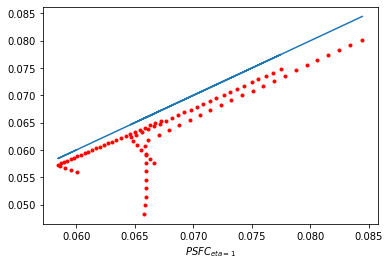

In [57]:
ytest= rhea_MCR.Ratio.values
y= rhea_MCR_09.Ratio.values

fig = plt.figure()
plt.plot(ytest, ytest, '-', label='$PSFC_{eta=1}$')
plt.plot(ytest, y, 'r.', label='$PSFC_{eta=0.9}$')
   
plt.xlabel('$PSFC_{eta=1}$')

In [15]:
T4=turbine_inlet_temperature
speeds=[0.01,0.05,0.12,0.15,0.18,0.22,0.25,0.28,0.3,0.32,0.35,0.38,0.4,0.42,0.45,0.48,0.5]        
altitudes = np.linspace(0,25000,30)*constants.foot

def create_df(phase,throttle):
    df= pd.DataFrame()
    for mach in speeds:
        for altitude in altitudes:
            atmosphere = Atmosphere(altitude, altitude_in_feet=False)
            if throttle==1:
                max_shaft_power,max_thermo_power,Shp_gb_limit,engine_charac,thermo_data = TPEngine_L1.compute_power(atmosphere, mach, phase, T4)        
                out_power = max_shaft_power
                T_prop, eta =Propeller().power_to_thrust_ADT(TPEngine_L1,atmosphere, mach,phase, out_power)
            else:
                max_shaft_power,max_thermo_power,Shp_gb_limit,engine_charac,thermo_data = TPEngine_L1.compute_power(atmosphere, mach, phase, T4)
                out_power,thermo_power,gb_limit_power, engine_charac,thermo_data =TPEngine_L1.compute_engine_point(atmosphere, mach, phase,max_shaft_power*throttle)
                T_prop, eta =Propeller().power_to_thrust_ADT(TPEngine_L1,atmosphere, mach,phase, out_power)
                
            #deck validation
            df = df.append({'Altitude':altitude/constants.foot,'Mach':mach, 'SHP':float(out_power)/constants.hp,'Throttle':throttle,'PSFC':float(engine_charac[0]*60*60)/(float(out_power)/constants.hp)}, ignore_index=True)

    return df   
            
        #rating validation
        # print(max_shaft_power/constants.hp,max_thermo_power/constants.hp,Shp_gb_limit/constants.hp,engine_charac[0],engine_charac[1]/10)
#TO = 1,MCL = 2,MCR = 3,FID = 4, RTO = 8'''


In [13]:
rhea_MCL=create_df(2,1)
display(rhea_MCL)
rhea_MCL.to_csv('TP_L1_deck_MCL.csv')

,Altitude,Mach,PSFC,SHP,Throttle
0,0.000000,0.01,0.269648,2139.280824,1.0
1,1034.482759,0.01,0.263522,2139.280824,1.0
2,2068.965517,0.01,0.257497,2139.280824,1.0
3,3103.448276,0.01,0.251571,2139.280824,1.0
4,4137.931034,0.01,0.245744,2139.280824,1.0
5,5172.413793,0.01,0.241693,2124.422780,1.0
6,6206.896552,0.01,0.240075,2088.549392,1.0
7,7241.379310,0.01,0.238478,2052.866114,1.0
8,8275.862069,0.01,0.236901,2017.380278,1.0
9,9310.344828,0.01,0.235345,1982.099232,1.0


In [27]:
rhea_MCR=create_df(3,1)
rhea_MCR_09=create_df(3,0.9)
rhea_MCR_08=create_df(3,0.8)
rhea_MCR_07=create_df(3,0.7)
rhea_MCR_06=create_df(3,0.6)
rhea_MCR_05=create_df(3,0.5)
rhea_MCR_04=create_df(3,0.4)
rhea_MCR_01=create_df(3,0.1)


,Altitude,Mach,PSFC,SHP,Throttle
0,0.000000,0.01,0.265826,2080.229158,1.0
1,1034.482759,0.01,0.259778,2080.229158,1.0
2,2068.965517,0.01,0.256002,2062.578224,1.0
3,3103.448276,0.01,0.254174,2029.530096,1.0
4,4137.931034,0.01,0.252371,1996.610630,1.0
5,5172.413793,0.01,0.250593,1963.827234,1.0
6,6206.896552,0.01,0.248839,1931.187219,1.0
7,7241.379310,0.01,0.247108,1898.697816,1.0
8,8275.862069,0.01,0.245400,1866.366184,1.0
9,9310.344828,0.01,0.243716,1834.199441,1.0


In [30]:
rhea_MCR_tot=rhea_MCR.append([rhea_MCR_09,rhea_MCR_08,rhea_MCR_07,rhea_MCR_06,rhea_MCR_05,rhea_MCR_04,rhea_MCR_01], ignore_index=True)
display(rhea_MCR_tot)
rhea_MCR_tot.to_csv('TP_L1_deck_CRZ.csv')


,Altitude,Mach,PSFC,SHP,Throttle
0,0.000000,0.01,0.265826,2080.229158,1.0
1,1034.482759,0.01,0.259778,2080.229158,1.0
2,2068.965517,0.01,0.256002,2062.578224,1.0
3,3103.448276,0.01,0.254174,2029.530096,1.0
4,4137.931034,0.01,0.252371,1996.610630,1.0
5,5172.413793,0.01,0.250593,1963.827234,1.0
6,6206.896552,0.01,0.248839,1931.187219,1.0
7,7241.379310,0.01,0.247108,1898.697816,1.0
8,8275.862069,0.01,0.245400,1866.366184,1.0
9,9310.344828,0.01,0.243716,1834.199441,1.0


In [16]:
rhea_MCT=create_df(9,1)
rhea_NTO=create_df(1,1)
rhea_RTO=create_df(8,1)

In [17]:
rhea_MCT.to_csv('TP_L1_deck_MCT.csv')
rhea_NTO.to_csv('TP_L1_deck_NTO.csv')
rhea_RTO.to_csv('TP_L1_deck_RTO.csv')

In [22]:
display(rhea_RTO)

,Altitude,Mach,PSFC,SHP,Throttle
0,0.000000,0.01,0.266678,2684.166655,1.0
1,862.068966,0.01,0.261663,2684.166655,1.0
2,1724.137931,0.01,0.256717,2684.166655,1.0
3,2586.206897,0.01,0.251839,2684.166655,1.0
4,3448.275862,0.01,0.247028,2684.166655,1.0
5,4310.344828,0.01,0.242283,2684.166655,1.0
6,5172.413793,0.01,0.237604,2684.166655,1.0
7,6034.482759,0.01,0.232991,2684.166655,1.0
8,6896.551724,0.01,0.228442,2684.166655,1.0
9,7758.620690,0.01,0.223958,2684.166655,1.0
